In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from bitstring import ConstBitStream
import os
import re
import pickle
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


n_mels = 64
frames = 5
n_fft = 2048
hop_length= 256
power = 2.0
sr = 48000


In [2]:
def read_custom_i32(filepath):
    with open(filepath, 'rb') as file:
        raw = ConstBitStream(file)
        count = raw.len // 32
        float_array = []
        for i in range(count):
            value = raw.read('floatle:32')
            float_array.append(value)

    return np.array(float_array)


def plot_wave(normal_array,abnormal_array):

    # Plotting the signals using librosa.display.waveshow
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 3, 1)
    librosa.display.waveshow(normal_array, sr=48000, alpha=0.5, color='blue')
    plt.title('Normal signal')

    plt.subplot(1, 3, 2)
    librosa.display.waveshow(abnormal_array, sr=48000, alpha=0.6, color='red')
    plt.title('Abnormal signal')

    plt.subplot(1,3,3)
    librosa.display.waveshow(normal_array, sr=48000, alpha=0.6, color='blue', linewidth=0.5, label='Normal signal')
    librosa.display.waveshow(abnormal_array, sr=48000, alpha=0.5, color='red', linewidth=0.5, label='Abormal signal')
    plt.title('Both signals')

    plt.suptitle('2D representation of the given data wave forms', fontsize=16)
    plt.show()


def plot_after_stft(D_normal, D_abnormal):
    # Plotting the Fourier transform for the first 64ms window
    plt.figure(figsize=(12, 6))
    plt.plot(D_normal, color='blue', alpha=0.6, label='Machine - Normal signal')
    plt.plot(D_abnormal, color='red', alpha=0.6, label='Machine - Abnormal signal')
    plt.title('Fourier transform for the first 64ms window')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)  
    plt.xlim(0, 200)  # Adjust the limits for better visualization if needed
    plt.show()


def calculate_spectrogram(signal, sr, n_fft, hop_length):
    spectrogram = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
    return spectrogram

# Function to plot spectrogram
def plot_spectrogram(spectrogram, sr, title):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.ylim(0, 500)  # Adjust the frequency range as needed
    plt.show()

# Function to plot both normal and abnormal signals' spectrograms
def plot_signals_spectrograms(normal_signal, abnormal_signal, sr, n_fft, hop_length):
    spectrogram_normal = calculate_spectrogram(normal_signal[:20 * n_fft], sr, n_fft, hop_length)
    spectrogram_abnormal = calculate_spectrogram(abnormal_signal[:20 * n_fft], sr, n_fft, hop_length)

    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    
    spec_normal = librosa.display.specshow(spectrogram_normal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis', ax=axes[0])
    axes[0].set_title('Machine - Normal signal')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].grid(True)
    plt.colorbar(spec_normal, ax=axes[0])  # Use spec_normal as the mappable object for colorbar

    spec_abnormal = librosa.display.specshow(spectrogram_abnormal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis', ax=axes[1])
    axes[1].set_title('Machine - Abnormal signal')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].grid(True)
    plt.colorbar(spec_abnormal, ax=axes[1])  # Use spec_abnormal as the mappable object for colorbar

    plt.tight_layout()
    plt.show()


def get_magnitude_scale(signal, sr, n_fft, hop_length):
    magnitude = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
    dB = librosa.amplitude_to_db(magnitude, ref=np.max)
    return dB

# Function to plot spectrogram with dB scale
def plot_spectrogram_with_dB(signal, sr, n_fft, hop_length, title):
    dB_scale = get_magnitude_scale(signal, sr, n_fft, hop_length)

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(dB_scale, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(title)
    plt.colorbar(format="%+2.f dB")
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

# Function to compute mel spectrogram and power to dB conversion
def compute_mel_spectrogram(signal, sr, n_fft, hop_length, n_mels):
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(mel, ref=np.max)
    return S_DB

# Function to plot mel spectrogram
def plot_mel_spectrogram(S_DB, sr, hop_length, title):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Function to generate frame-wise mel spectrogram plots
def plot_framewise_mel_spectrogram(S_DB, sr, hop_length, frames):
    dims = frames * S_DB.shape[0]
    features_vector_size = S_DB.shape[1] - frames + 1
    features = np.zeros((features_vector_size, dims), np.float32)
    for t in range(frames):
        features[:, S_DB.shape[0] * t: S_DB.shape[0] * (t + 1)] = S_DB[:, t:t + features_vector_size].T

    plt.figure(figsize=(24, 3))
    for t in range(frames):
        plt.subplot(1, frames, t + 1)
        librosa.display.specshow(features[:, S_DB.shape[0] * t: S_DB.shape[0] * (t + 1)].T, sr=sr, hop_length=hop_length, cmap='viridis')
        # Optionally add colorbars if needed
        # plt.colorbar(format='%+2.0f dB')
        plt.title(f'Frame {t + 1}')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
    plt.show()


def extract_cepstral_coefficients(filepath, sr, n_fft, hop_length, n_mfcc):
    signal_array = read_custom_i32(filepath)
    mfcc = librosa.feature.mfcc(y=signal_array, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    return mfcc


1. 96 hZ Mic 1

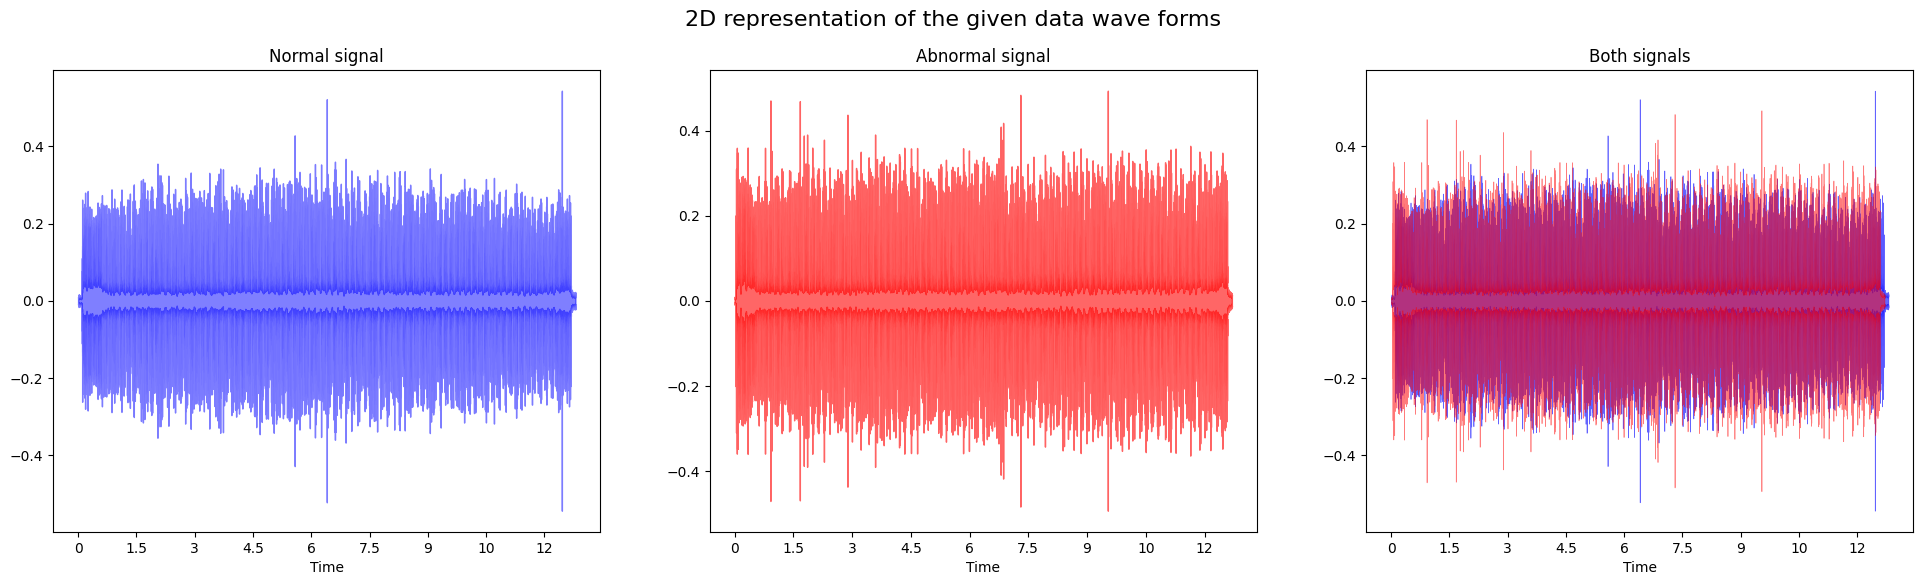

In [3]:

normal_signal_path = r'UseCase_2_MSG_Alu_FitAG\training_without_pores\Wall_17_AL_io_20220614\L01_09-56-46_io-pass\MikroSE81_48khz_float32_09-56-46.I32'
abnormal_signal_path = r"UseCase_2_MSG_Alu_FitAG\training_with_pores\Wall_22_AL_GF50_20220615\L01_09-08-20_io-pass\MikroSE81_48khz_float32_09-08-20.I32"

normal_array = read_custom_i32(normal_signal_path)
abnormal_array = read_custom_i32(abnormal_signal_path)

plot_wave(normal_array, abnormal_array)

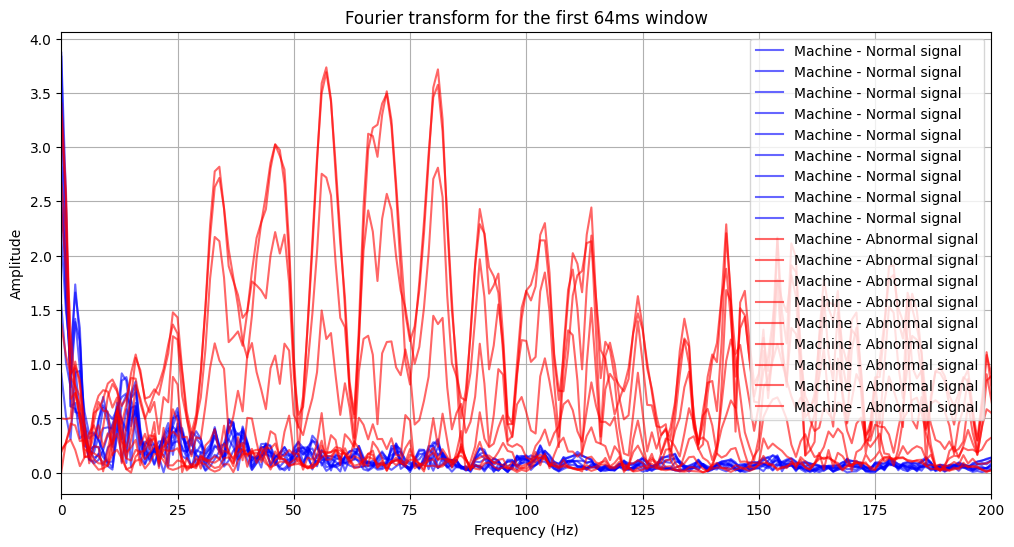

In [4]:
# Take the first 64ms window from each signal and compute the STFT
D_normal = np.abs(librosa.stft(normal_array[:n_fft], n_fft=n_fft, hop_length=hop_length))
D_abnormal = np.abs(librosa.stft(abnormal_array[:n_fft], n_fft=n_fft, hop_length=hop_length))

plot_after_stft(D_normal, D_abnormal)

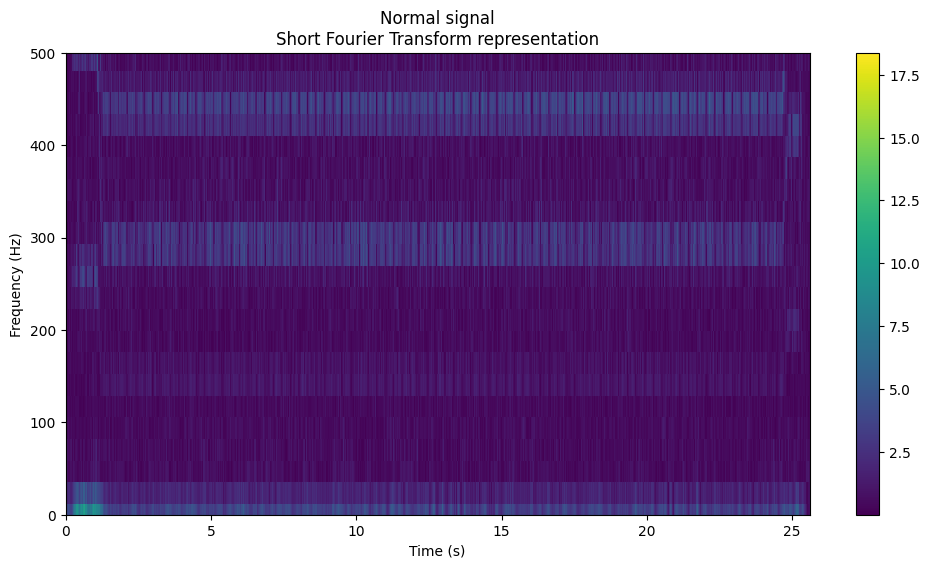

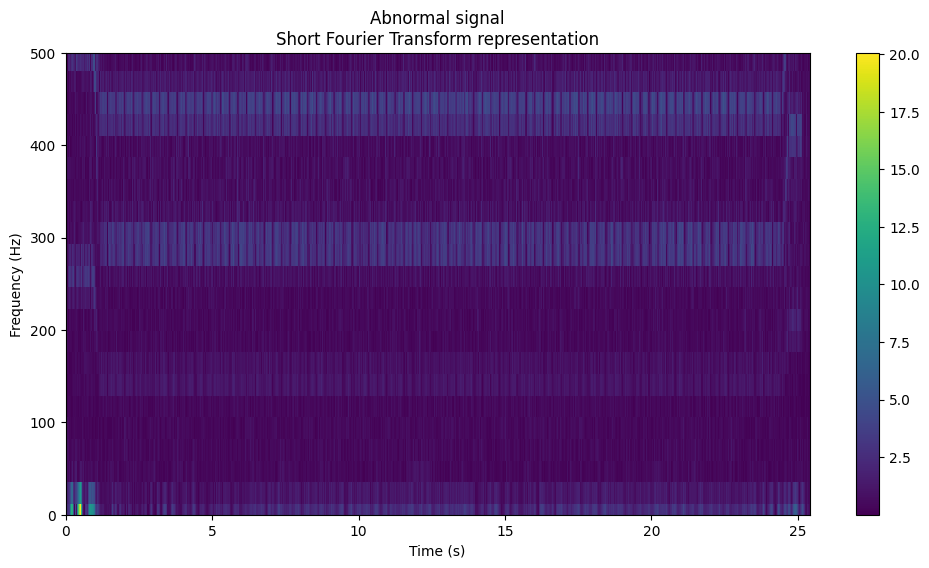

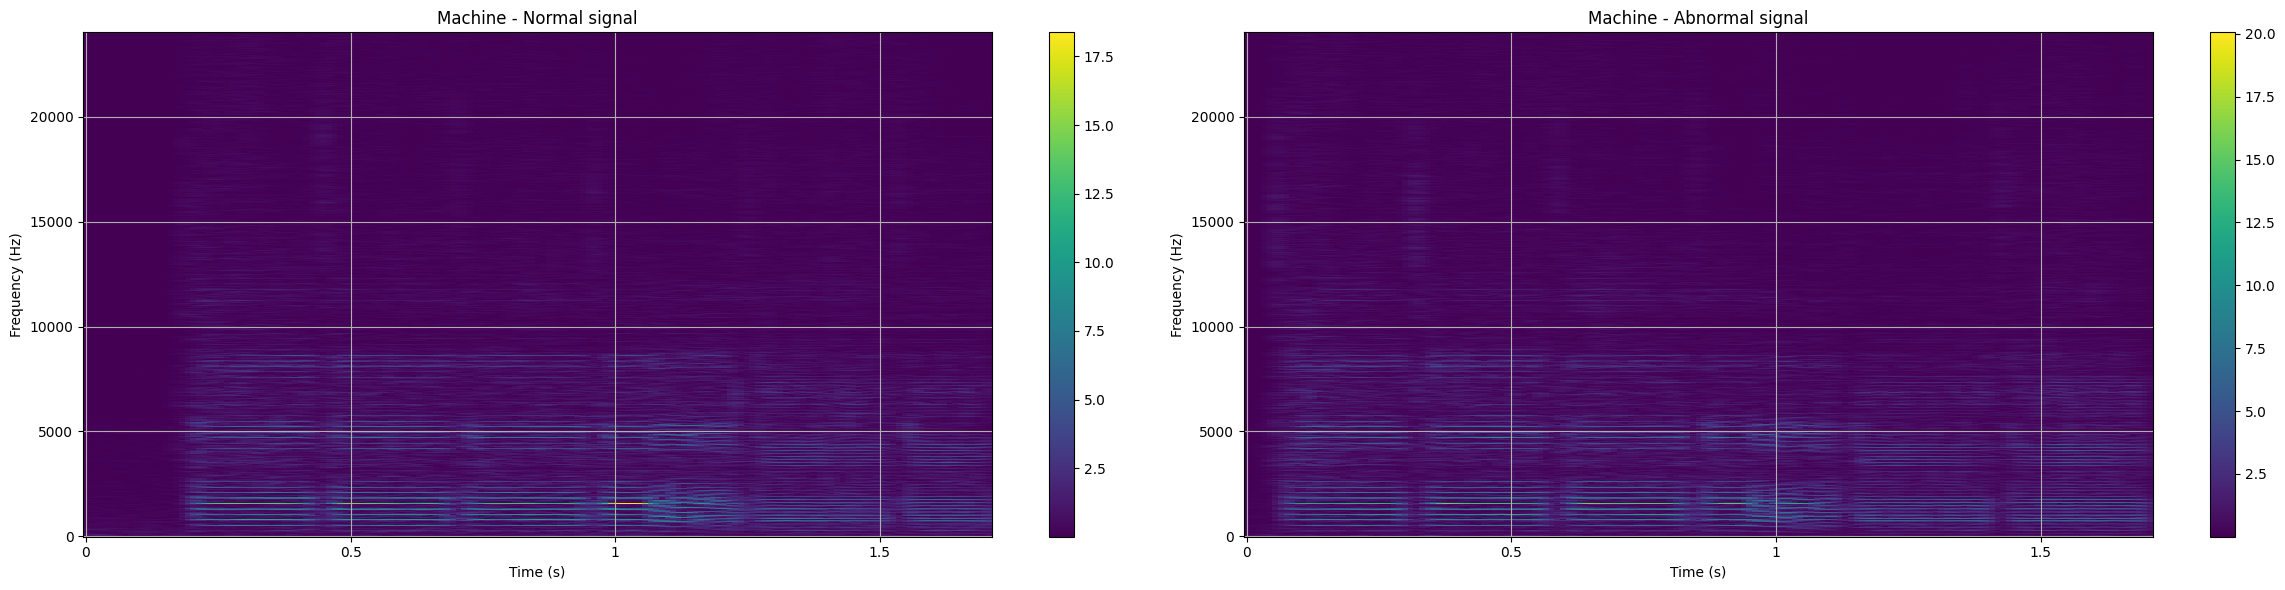

In [5]:
# Plotting spectrograms for individual signals (first 20*2048 samples)
spectrogram_normal = calculate_spectrogram(normal_array, sr, n_fft, hop_length)
plot_spectrogram(spectrogram_normal, sr, 'Normal signal\nShort Fourier Transform representation')

spectrogram_normal = calculate_spectrogram(abnormal_array, sr, n_fft, hop_length)
plot_spectrogram(spectrogram_normal, sr, 'Abnormal signal\nShort Fourier Transform representation')

# Plotting spectrograms for both normal and abnormal signals
plot_signals_spectrograms(normal_array, abnormal_array, sr, n_fft, hop_length)

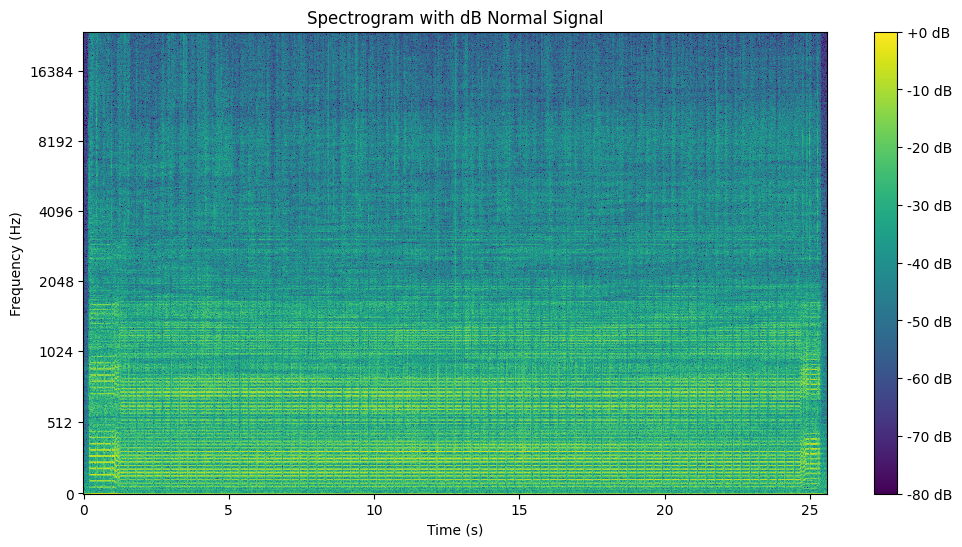

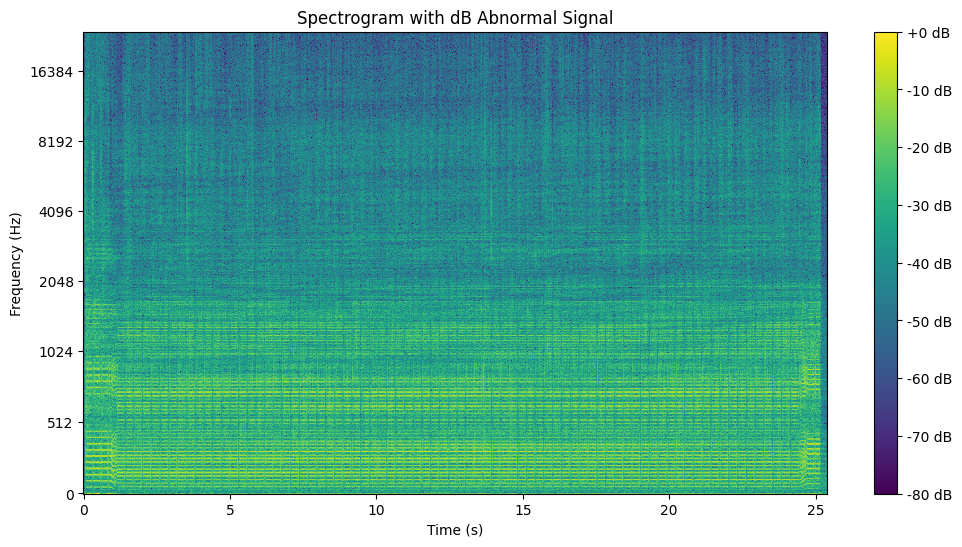

In [6]:
plot_spectrogram_with_dB(normal_array, sr, n_fft, hop_length, 'Spectrogram with dB Normal Signal')

plot_spectrogram_with_dB(abnormal_array, sr, n_fft, hop_length, 'Spectrogram with dB Abnormal Signal')

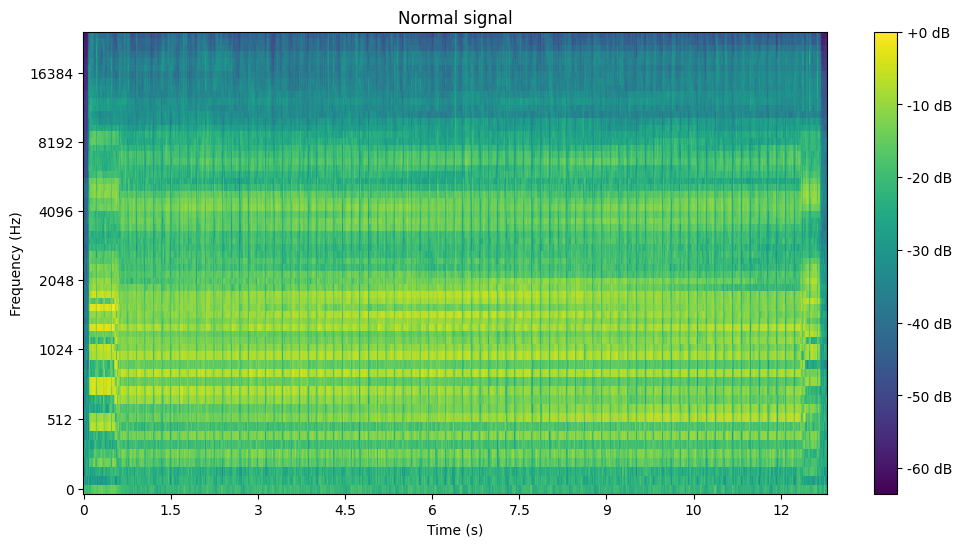

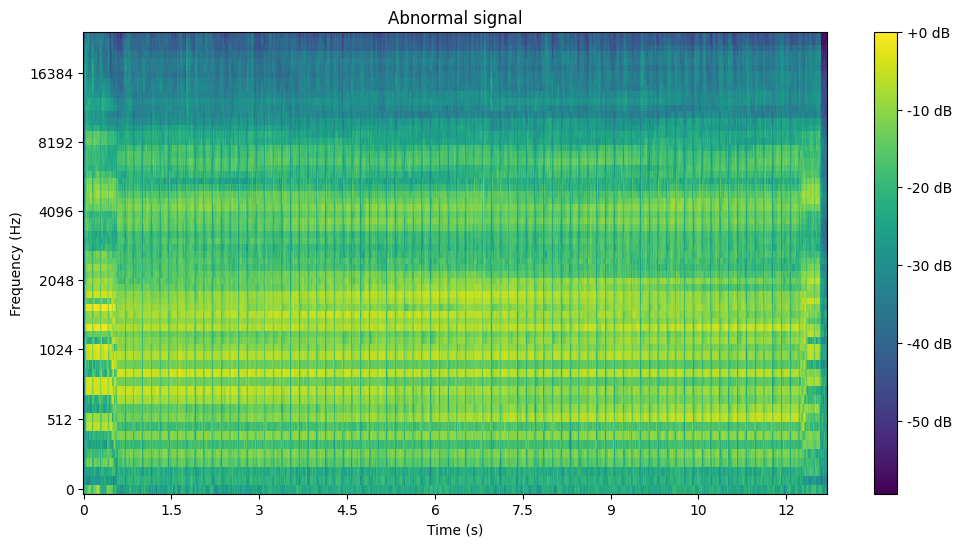

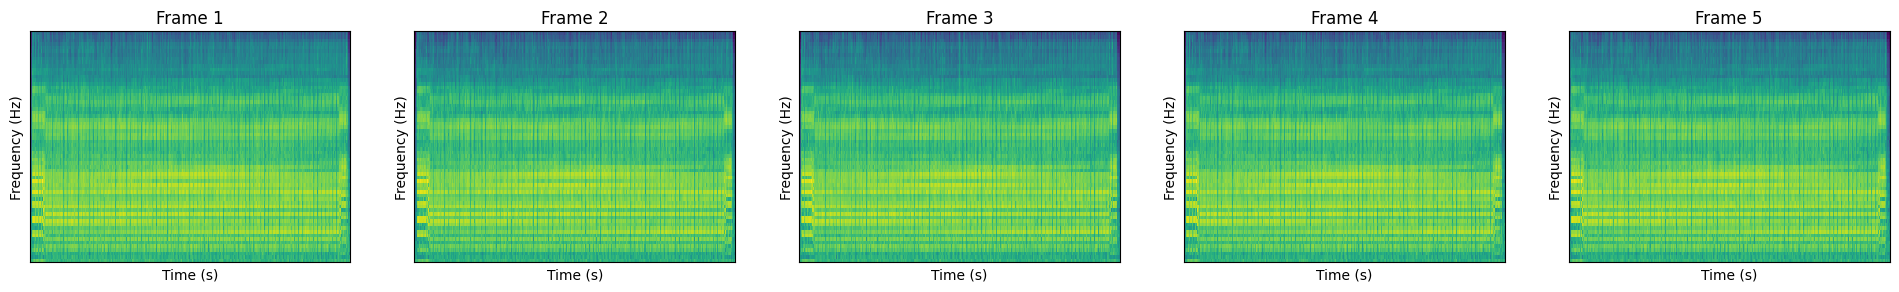

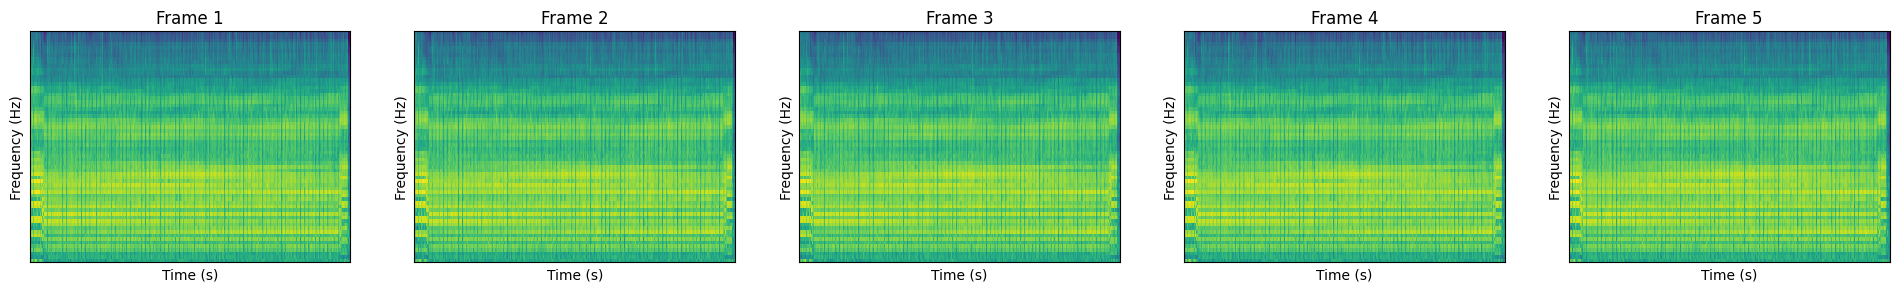

In [7]:
# Calculate mel spectrograms and power to dB conversion
normal_S_DB = compute_mel_spectrogram(normal_array, sr, n_fft, hop_length, n_mels)
abnormal_S_DB = compute_mel_spectrogram(abnormal_array, sr, n_fft, hop_length, n_mels)

# Plot mel spectrograms
plot_mel_spectrogram(normal_S_DB, sr, hop_length, 'Normal signal')
plot_mel_spectrogram(abnormal_S_DB, sr, hop_length, 'Abnormal signal')

# Plot frame-wise mel spectrograms
plot_framewise_mel_spectrogram(normal_S_DB, sr, hop_length, frames)
plot_framewise_mel_spectrogram(abnormal_S_DB, sr, hop_length, frames)

In [8]:
# Load training dataset
training_set_path = r"pickles\m1_48hz\train_without_pores_48hz_m1.pickle"

with open(training_set_path, 'rb') as file:
    training_data = pickle.load(file)

# Find the minimum shape along axis 1
min_shape = min(arr.shape[1] for arr in training_data)

# Trim or pad arrays to ensure they have the same shape along axis 1
training_data_processed = [arr[:, :min_shape] for arr in training_data]

# Concatenate the processed arrays
train_X = np.concatenate(training_data_processed, axis=0)

train_X = train_X.reshape(-1, 1)

# Define the architecture of the autoencoder
input_dim = train_X.shape[1]  # Define the input dimension based on the data
encoding_dim = 64  # Define the size of the encoding layer

# Define the autoencoder model
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = tf.keras.Model(input_layer, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error as the loss function

# Train the autoencoder
autoencoder.fit(train_X, train_X, epochs=30, batch_size=32)





Epoch 1/30

47640/47640 [==============================] - 37s 762us/step - loss: 821.0662
Epoch 2/30
47640/47640 [==============================] - 36s 748us/step - loss: 821.0588
Epoch 3/30
47640/47640 [==============================] - 37s 771us/step - loss: 821.0579
Epoch 4/30
47640/47640 [==============================] - 35s 728us/step - loss: 821.0522
Epoch 5/30
47640/47640 [==============================] - 35s 740us/step - loss: 821.0563
Epoch 6/30
47640/47640 [==============================] - 35s 739us/step - loss: 821.0594
Epoch 7/30
47640/47640 [==============================] - 35s 740us/step - loss: 821.0543
Epoch 8/30
47640/47640 [==============================] - 35s 744us/step - loss: 821.0537
Epoch 9/30
47640/47640 [==============================] - 39s 813us/step - loss: 821.0532
Epoch 10/30
47640/47640 [==============================] - 35s 742us/step - loss: 821.0583
Epoch 11/30
47640/47640 [==============================] - 33s 703us/step - loss: 821.0566
Epoch

In [9]:
# Loading testing dataset
test_set_path1 = r"pickles\m1_48hz\test_with_pores_48hz_m1.pickle"

with open(test_set_path1, 'rb') as file:
    test_data = pickle.load(file)

reconstruction_errors_w = []  # To store reconstruction errors

for mfcc_data in test_data:
    # Preprocess the MFCC data if needed to match the input shape expected by the Autoencoder
    # For example, reshape or modify dimensions
    mfcc_data = mfcc_data.reshape(-1, 1)
    # Predict the reconstructed output using the Autoencoder
    reconstructed = autoencoder.predict(mfcc_data)
    
    # Calculate the reconstruction error between original MFCC data and reconstructed output
    reconstruction_error = np.mean(np.square(mfcc_data - reconstructed))
    reconstruction_errors_w.append(reconstruction_error)

# reconstruction_errors now holds the errors for each MFCC sample



75/75 [==============================] - 0s 622us/step


In [10]:
# Loading testing dataset
test_set_path2 = r"pickles\m1_48hz\test_without_pores_48hz_m1.pickle"

with open(test_set_path2, 'rb') as file:
    test_data = pickle.load(file)

reconstruction_errors_wo = []  # To store reconstruction errors

for mfcc_data in test_data:
    # Preprocess the MFCC data if needed to match the input shape expected by the Autoencoder
    # For example, reshape or modify dimensions
    mfcc_data = mfcc_data.reshape(-1, 1)
    # Predict the reconstructed output using the Autoencoder
    reconstructed = autoencoder.predict(mfcc_data)
    
    # Calculate the reconstruction error between original MFCC data and reconstructed output
    reconstruction_error = np.mean(np.square(mfcc_data - reconstructed))
    reconstruction_errors_wo.append(reconstruction_error)

# reconstruction_errors now holds the errors for each MFCC sample



75/75 [==============================] - 0s 596us/step


In [11]:

# Generating labels for the test data without pores
test_labels_wo = np.zeros(len(reconstruction_errors_wo))  # Labeling data without pores as normal
y_true_wo = test_labels_wo

# Generating labels for the test data with pores
test_labels_w = np.ones(len(reconstruction_errors_w))  # Labeling data with pores as abnormal
y_true_w = test_labels_w

# Concatenating labels from both sets to form the combined test labels
test_labels_combined = np.concatenate((y_true_wo, y_true_w), axis=0)

# Assigning the combined labels to y_true for further evaluation
y_true = test_labels_combined

# Concatenating labels from both sets to form the combined test labels
reconstruction_errors = np.concatenate((reconstruction_errors_wo, reconstruction_errors_w), axis=0)


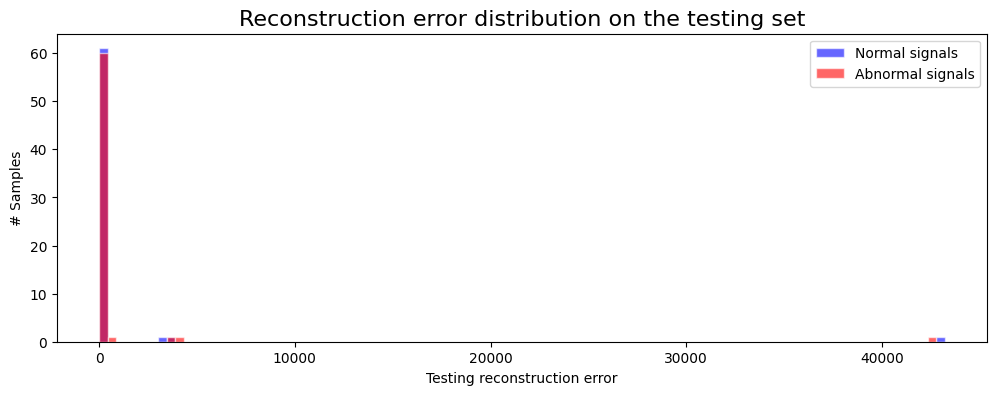

In [12]:
# Shuffling indices
shuffled_indices = np.random.permutation(len(y_true))

# Shuffle the y_true labels and reconstruction_errors based on the shuffled indices
y_true_shuffled = y_true[shuffled_indices]
reconstruction_errors_shuffled = reconstruction_errors[shuffled_indices]

data = np.column_stack((range(len(reconstruction_errors_shuffled)), reconstruction_errors_shuffled))

# Calculate appropriate bin width based on the data range for data with pores
bin_width = (max(reconstruction_errors_shuffled) - min(reconstruction_errors_shuffled)) / 100
bins = np.arange(min(reconstruction_errors_shuffled), max(reconstruction_errors_shuffled) + bin_width, bin_width)

fig = plt.figure(figsize=(12,4))
plt.hist(data[y_true_shuffled==0][:,1], bins=bins, color='blue', alpha=0.6, label='Normal signals', edgecolor='#FFFFFF')
plt.hist(data[y_true_shuffled==1][:,1], bins=bins, color='red', alpha=0.6, label='Abnormal signals', edgecolor='#FFFFFF')
plt.xlabel("Testing reconstruction error")
plt.ylabel("# Samples")
plt.title('Reconstruction error distribution on the testing set', fontsize=16)
plt.legend()
plt.show()



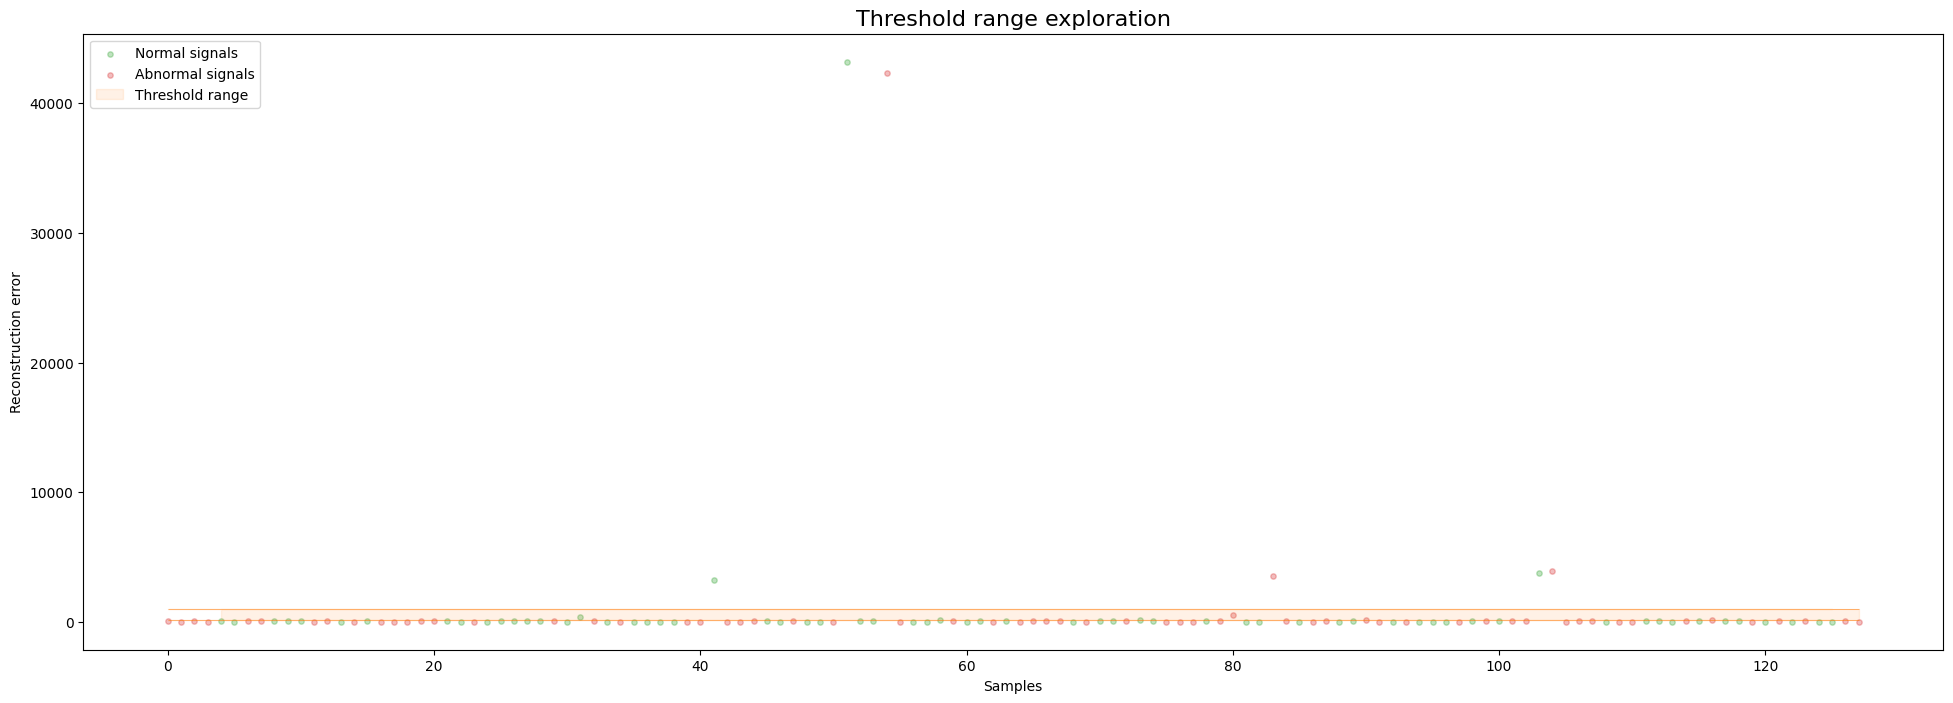

In [13]:
# Set threshold ranges:
threshold_min = 100.0
threshold_max = 1000.0
threshold_step = 0.10
# Scatter data for normal and abnormal signals:
normal_x, normal_y = data[y_true_shuffled==0][:,0], data[y_true_shuffled==0][:,1]
abnormal_x, abnormal_y = data[y_true_shuffled==1][:,0], data[y_true_shuffled==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24,8))
plt.scatter(normal_x, normal_y, s=15, color='tab:green', alpha=0.3, label='Normal signals')
plt.scatter(abnormal_x, abnormal_y, s=15, color='tab:red', alpha=0.3,   label='Abnormal signals')
plt.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='tab:orange', label='Threshold range')
plt.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='tab:orange')
plt.legend(loc='upper left')
plt.title('Threshold range exploration', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Reconstruction error')
plt.show()

In [14]:
import pickle
import numpy as np
import tensorflow as tf

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(test_data, autoencoder):
    reconstruction_errors = []
    for mfcc_data in test_data:
        # Preprocess the MFCC data if needed to match the input shape expected by the Autoencoder
        # For example, reshape or modify dimensions
        mfcc_data = mfcc_data.reshape(-1, 1)
        # Predict the reconstructed output using the Autoencoder
        reconstructed = autoencoder.predict(mfcc_data)
        # Calculate the reconstruction error between original MFCC data and reconstructed output
        reconstruction_error = np.mean(np.square(mfcc_data - reconstructed))
        reconstruction_errors.append(reconstruction_error)
    return np.array(reconstruction_errors)

# Loading testing dataset with pores
test_set_path1 = r"pickles\m1_48hz\test_with_pores_48hz_m1.pickle"
with open(test_set_path1, 'rb') as file:
    test_data_w = pickle.load(file)

# Calculate reconstruction errors for test data with pores
reconstruction_errors_w = calculate_reconstruction_errors(test_data_w, autoencoder)

# Loading testing dataset without pores
test_set_path2 = r"pickles\m1_48hz\test_without_pores_48hz_m1.pickle"
with open(test_set_path2, 'rb') as file:
    test_data_wo = pickle.load(file)

# Calculate reconstruction errors for test data without pores
reconstruction_errors_wo = calculate_reconstruction_errors(test_data_wo, autoencoder)

# Generating labels for the test data without pores
y_true_wo = np.zeros(len(reconstruction_errors_wo))  # Labeling data without pores as normal

# Generating labels for the test data with pores
y_true_w = np.ones(len(reconstruction_errors_w))  # Labeling data with pores as abnormal

# Concatenating labels from both sets to form the combined test labels
y_true = np.concatenate((y_true_wo, y_true_w), axis=0)

# Concatenating reconstruction errors from both sets to form the combined reconstruction errors
reconstruction_errors_combined = np.concatenate((reconstruction_errors_wo, reconstruction_errors_w), axis=0)

# Prepare combined feature set for CNN training
test_data_combined = np.concatenate((test_data_wo, test_data_w), axis=0)
test_data_combined_shuffled = test_data_combined  # Modify this line if shuffling is needed

# Reshape the combined feature set if needed
test_data_combined_shuffled = test_data_combined_shuffled.reshape(test_data_combined_shuffled.shape[0], -1)

# Your CNN architecture for training
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(test_data_combined_shuffled.shape[1],)),  # Adjust input_shape based on your data
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
model.fit(test_data_combined_shuffled, y_true, epochs=100, batch_size=34, validation_split=0.2)

# model.save("cnn_trained_48hz_m1.h5")


75/75 [==============================] - 0s 598us/step
Epoch 1/100

3/3 [==============================] - 1s 70ms/step - loss: 4.3949 - accuracy: 0.5980 - val_loss: 0.3928 - val_accuracy: 0.8846
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 2.0780 - accuracy: 0.5784 - val_loss: 1.9219 - val_accuracy: 0.2692
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 3.4862 - accuracy: 0.6863 - val_loss: 1.0404 - val_accuracy: 0.6538
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2050 - accuracy: 0.7647 - val_loss: 2.5288 - val_accuracy: 0.4231
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 6.5794 - accuracy: 0.7647 - val_loss: 5.3453 - val_accuracy: 0.0769
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 4.9441 - accuracy: 0.7255 - val_loss: 0.5553 - val_accuracy: 0.8077
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 2.1976 - accuracy: 0.7451 - val_

C:\Users\Swithinraj M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# Load the trained CNN model
model_cnn = tf.keras.models.load_model('pickles\m1_48hz\cnn_trained_48hz_m1.h5')


cnn_test_path = r"pickles\m1_48hz\test_without_pores_48hz_m1.pickle"

with open(cnn_test_path, 'rb') as file:
    test_data = pickle.load(file)

# Assuming test_data is a list of NumPy arrays
reshaped_test_data = np.array([mfcc_array.flatten() for mfcc_array in test_data])

# Determine the number of columns based on the size of the original data
num_columns = reshaped_test_data.size // reshaped_test_data.shape[0]

# Ensure that the reshaped_test_data has the correct number of columns
reshaped_test_data = reshaped_test_data.reshape(-1, num_columns)

# Verify the shape of reshaped_test_data
print(reshaped_test_data.shape)

predictions = model_cnn.predict(reshaped_test_data)


(64, 2382)
2/2 [==============================] - 0s 2ms/step


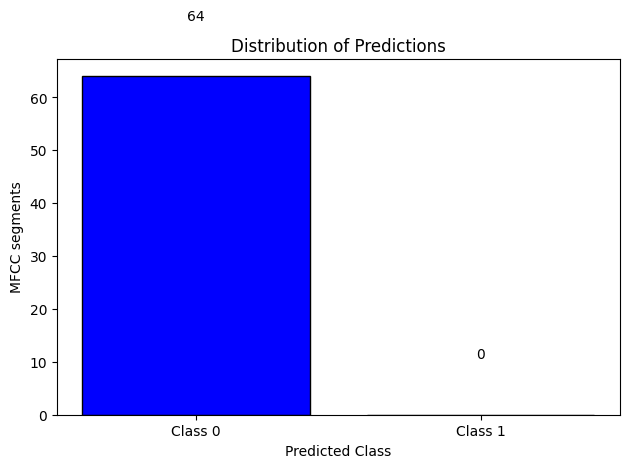

In [38]:
threshold = 0.7
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

# Count occurrences of each class
counts = [binary_predictions.count(0), binary_predictions.count(1)]

# Creating a histogram to visualize the distribution of predictions
plt.bar([0, 1], counts, color=['blue', 'red'], edgecolor='black')

# Labeling bars with their respective frequencies
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.xlabel('Predicted Class')
plt.ylabel('MFCC segments')
plt.xticks([0, 1], ['Class 0', 'Class 1'])  
plt.title('Distribution of Predictions')

plt.tight_layout()
plt.show()

2. 96 hZ Mic2

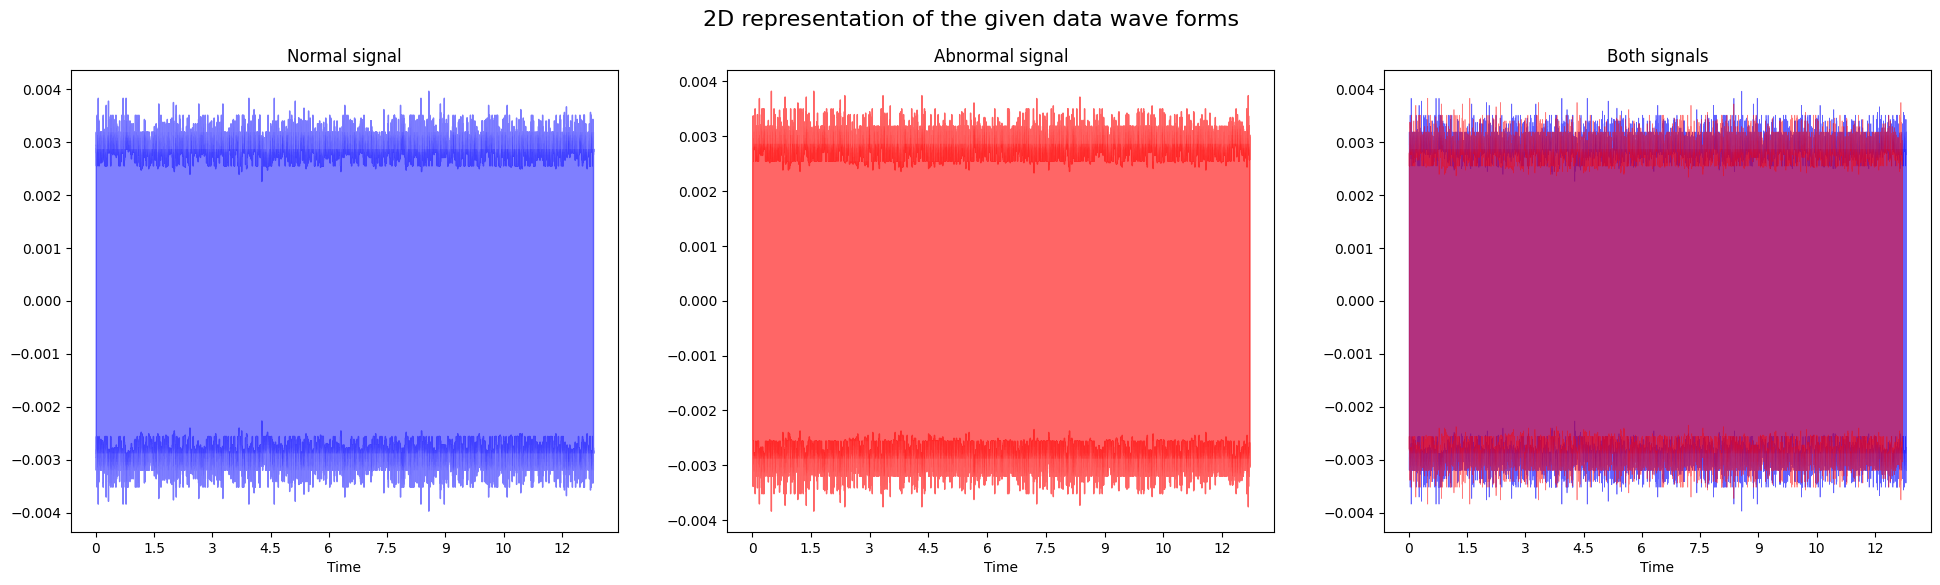

In [17]:

normal_signal_path = r'UseCase_2_MSG_Alu_FitAG\training_without_pores\Wall_17_AL_io_20220614\L01_09-56-46_io-pass\MikroSE82_48khz_float32_09-56-46.I32'
abnormal_signal_path = r"UseCase_2_MSG_Alu_FitAG\training_with_pores\Wall_22_AL_GF50_20220615\L01_09-08-20_io-pass\MikroSE82_48khz_float32_09-08-20.I32"

normal_array = read_custom_i32(normal_signal_path)
abnormal_array = read_custom_i32(abnormal_signal_path)

plot_wave(normal_array, abnormal_array)

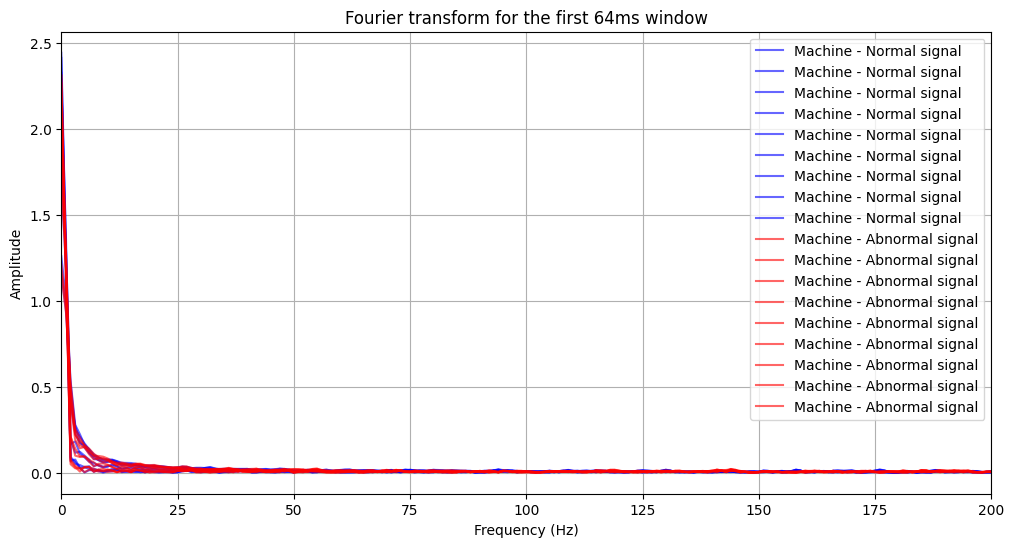

In [18]:
D_normal = np.abs(librosa.stft(normal_array[:n_fft], n_fft=n_fft, hop_length=hop_length))
D_abnormal = np.abs(librosa.stft(abnormal_array[:n_fft], n_fft=n_fft, hop_length=hop_length))

plot_after_stft(D_normal, D_abnormal)

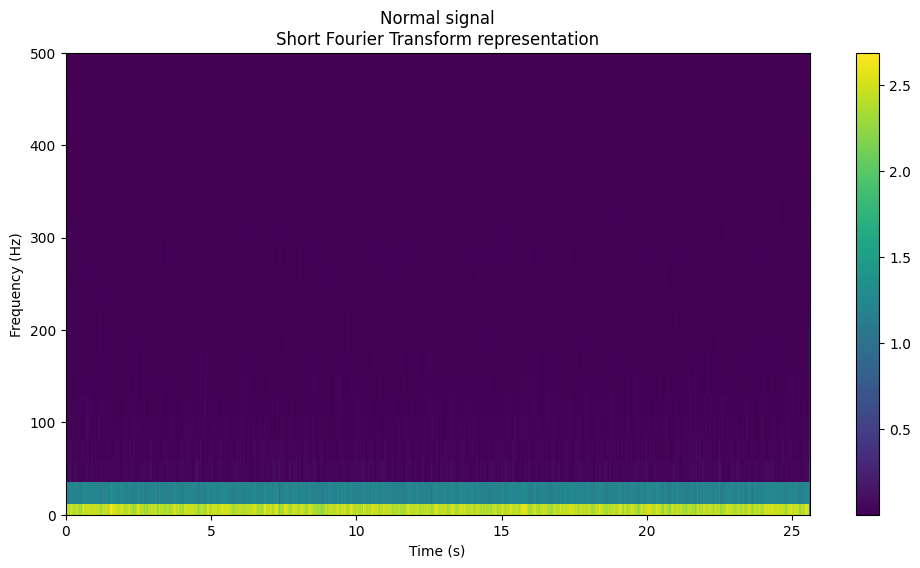

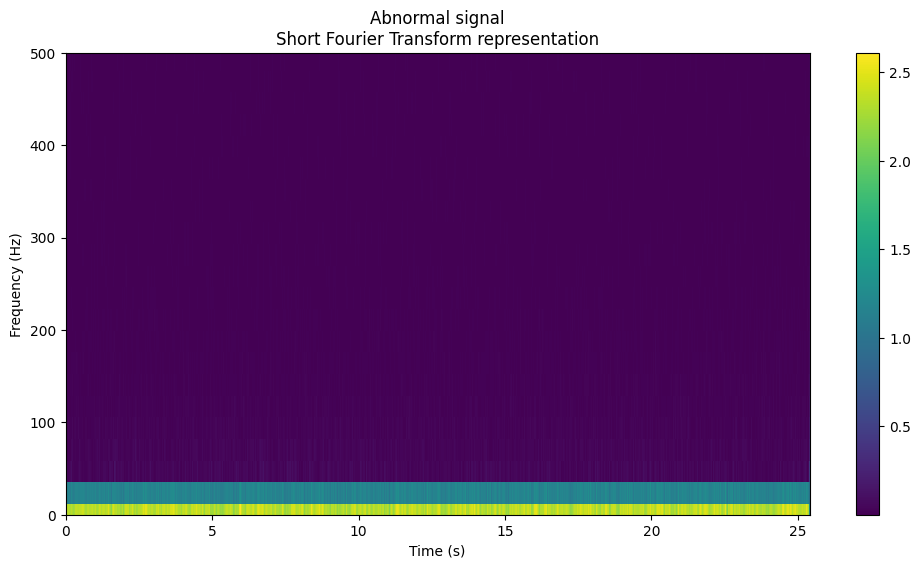

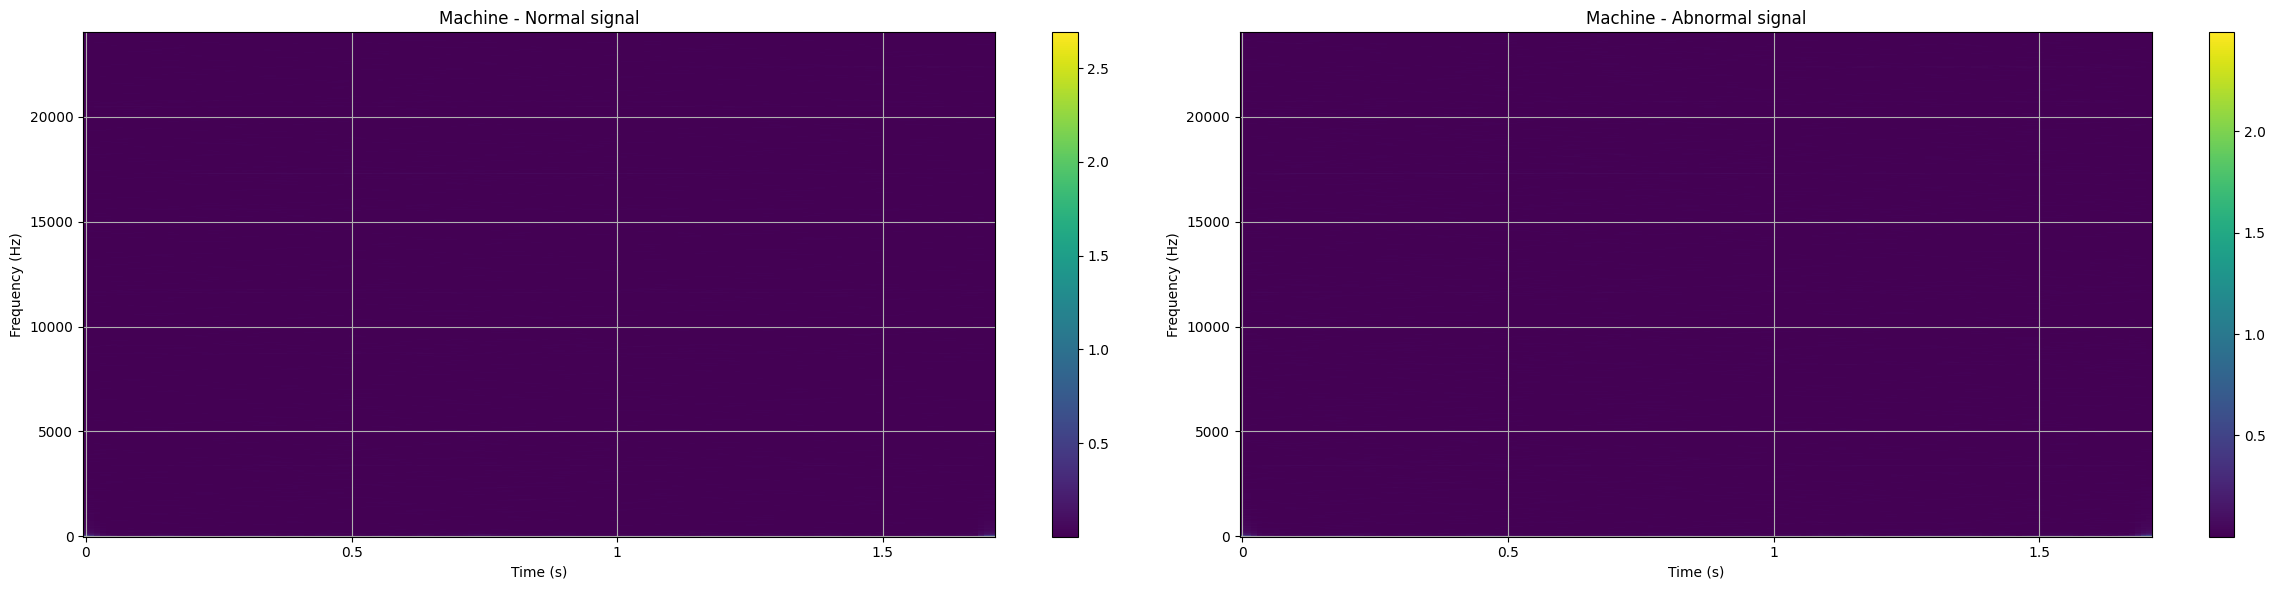

In [19]:
spectrogram_normal = calculate_spectrogram(normal_array, sr, n_fft, hop_length)
plot_spectrogram(spectrogram_normal, sr, 'Normal signal\nShort Fourier Transform representation')

spectrogram_normal = calculate_spectrogram(abnormal_array, sr, n_fft, hop_length)
plot_spectrogram(spectrogram_normal, sr, 'Abnormal signal\nShort Fourier Transform representation')

plot_signals_spectrograms(normal_array, abnormal_array, sr, n_fft, hop_length)

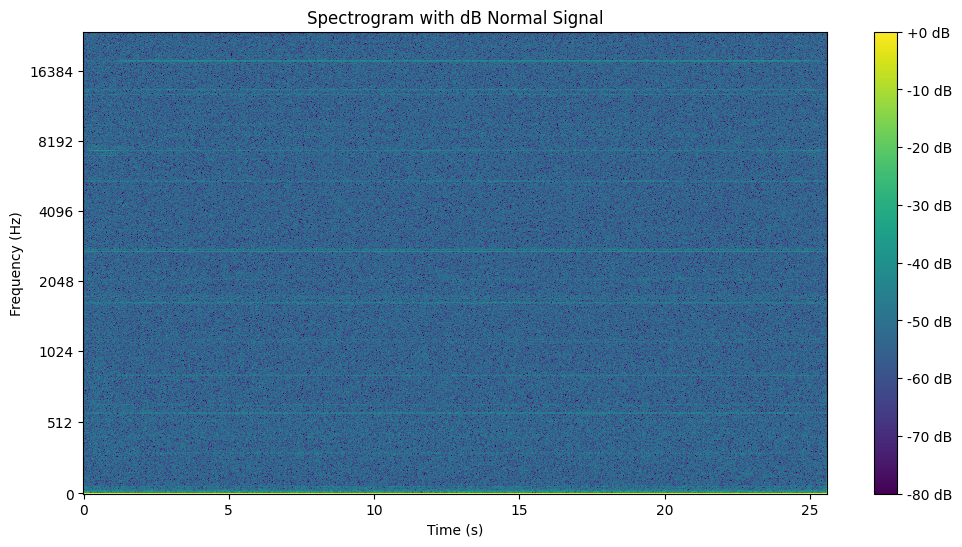

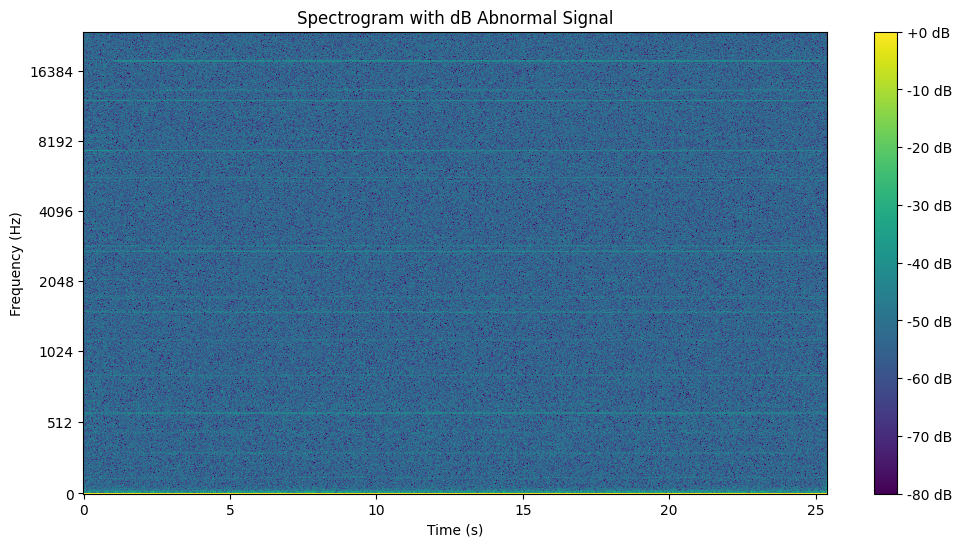

In [20]:
plot_spectrogram_with_dB(normal_array, sr, n_fft, hop_length, 'Spectrogram with dB Normal Signal')

plot_spectrogram_with_dB(abnormal_array, sr, n_fft, hop_length, 'Spectrogram with dB Abnormal Signal')

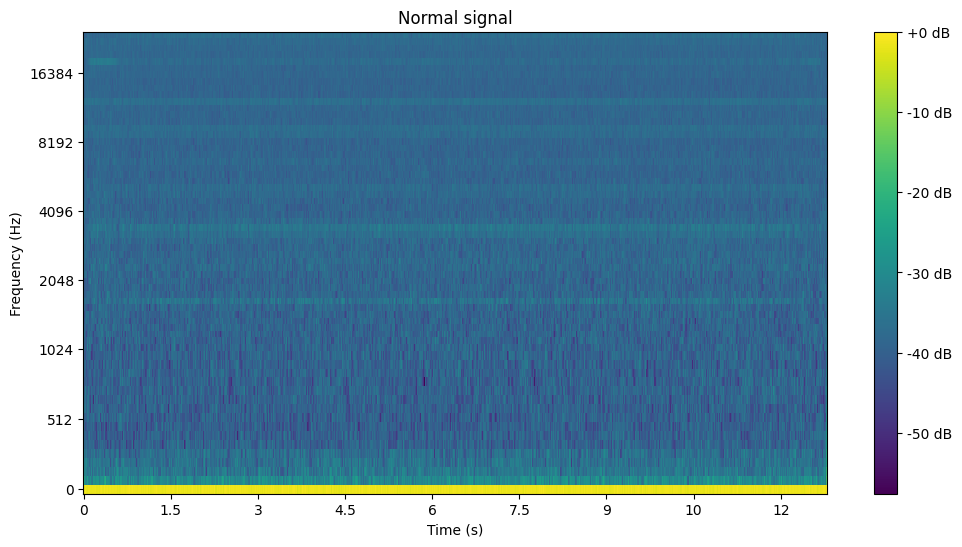

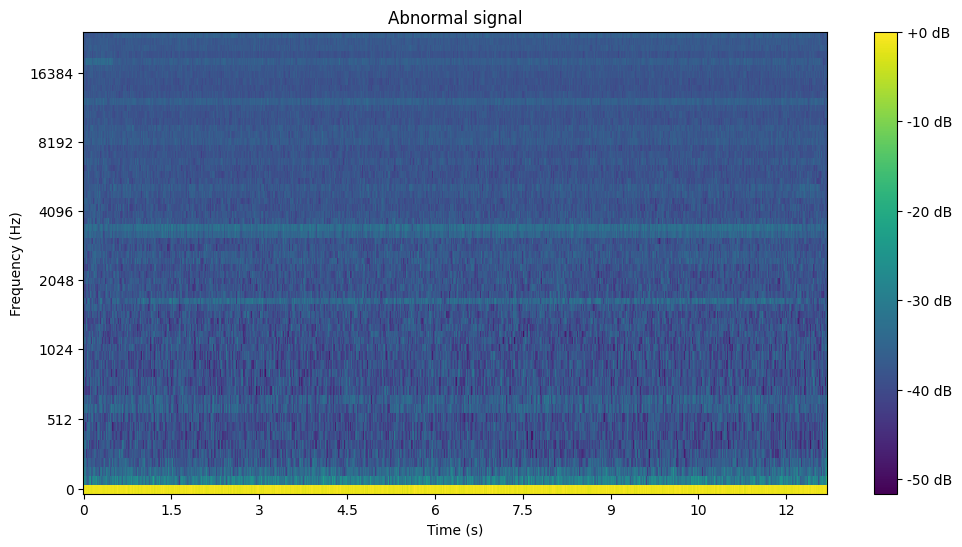

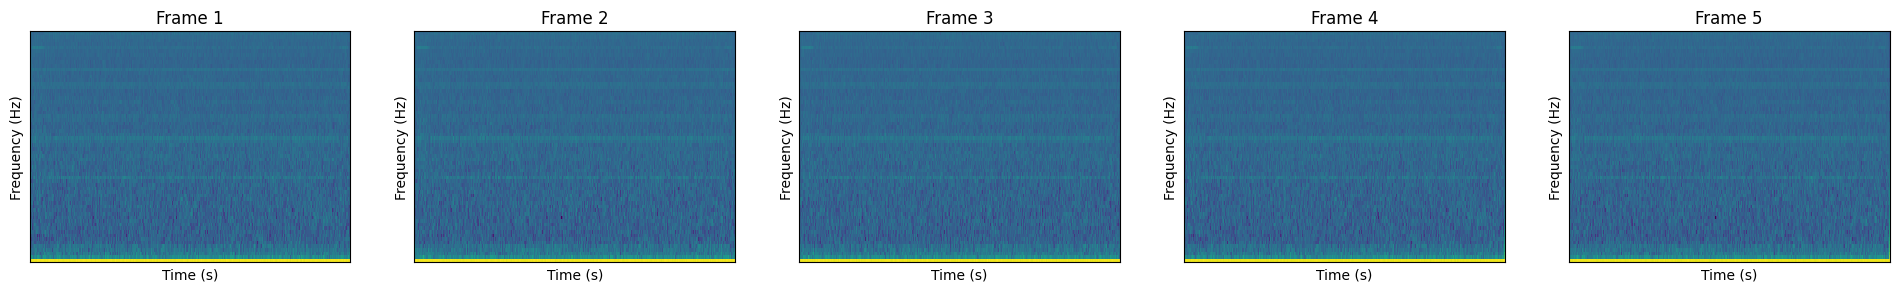

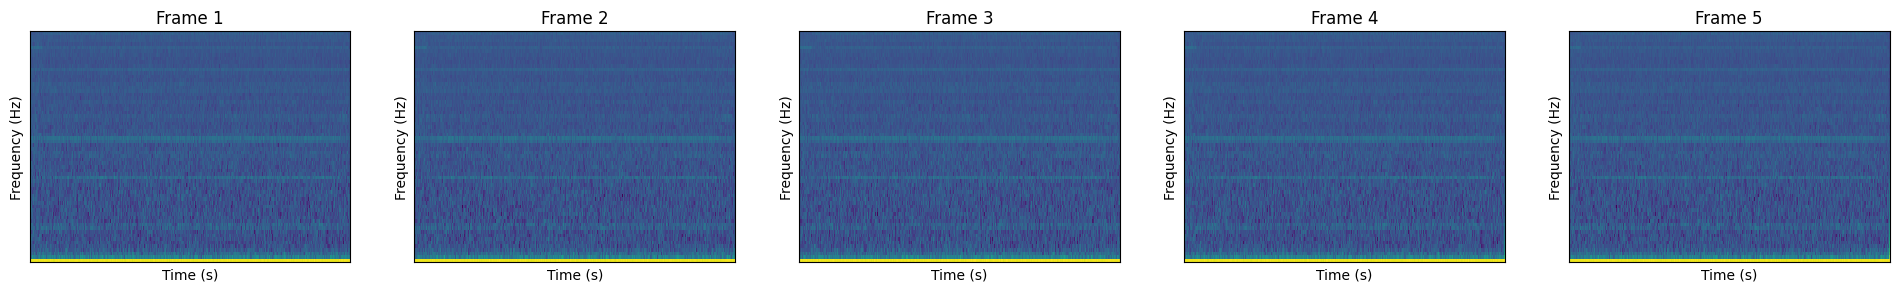

In [21]:
# Calculate mel spectrograms and power to dB conversion
normal_S_DB = compute_mel_spectrogram(normal_array, sr, n_fft, hop_length, n_mels)
abnormal_S_DB = compute_mel_spectrogram(abnormal_array, sr, n_fft, hop_length, n_mels)

# Plot mel spectrograms
plot_mel_spectrogram(normal_S_DB, sr, hop_length, 'Normal signal')
plot_mel_spectrogram(abnormal_S_DB, sr, hop_length, 'Abnormal signal')

# Plot frame-wise mel spectrograms
plot_framewise_mel_spectrogram(normal_S_DB, sr, hop_length, frames)
plot_framewise_mel_spectrogram(abnormal_S_DB, sr, hop_length, frames)

In [22]:
# Load training dataset
training_set_path = r"pickles\m2_48hz\train_without_pores_48hz_m2.pickle"

with open(training_set_path, 'rb') as file:
    training_data = pickle.load(file)

# Find the minimum shape along axis 1
min_shape = min(arr.shape[1] for arr in training_data)

# Trim or pad arrays to ensure they have the same shape along axis 1
training_data_processed = [arr[:, :min_shape] for arr in training_data]

# Concatenate the processed arrays
train_X = np.concatenate(training_data_processed, axis=0)

train_X = train_X.reshape(-1, 1)

# Define the architecture of the autoencoder
input_dim = train_X.shape[1]  # Define the input dimension based on the data
encoding_dim = 64  # Define the size of the encoding layer

# Define the autoencoder model
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = tf.keras.Model(input_layer, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error as the loss function

# Train the autoencoder
autoencoder.fit(train_X, train_X, epochs=30, batch_size=32)



Epoch 1/30
47640/47640 [==============================] - 34s 697us/step - loss: 7245.5752
Epoch 2/30
47640/47640 [==============================] - 33s 702us/step - loss: 7245.5723
Epoch 3/30
47640/47640 [==============================] - 35s 725us/step - loss: 7245.6323
Epoch 4/30
47640/47640 [==============================] - 34s 710us/step - loss: 7245.5874
Epoch 5/30
47640/47640 [==============================] - 34s 723us/step - loss: 7245.5913
Epoch 6/30
47640/47640 [==============================] - 34s 708us/step - loss: 7245.5508
Epoch 7/30
47640/47640 [==============================] - 34s 714us/step - loss: 7245.5605
Epoch 8/30
47640/47640 [==============================] - 34s 716us/step - loss: 7245.6294
Epoch 9/30
47640/47640 [==============================] - 34s 720us/step - loss: 7245.6470
Epoch 10/30
47640/47640 [==============================] - 36s 748us/step - loss: 7245.6455
Epoch 11/30
47640/47640 [==============================] - 38s 798us/step - loss: 7245.63

In [23]:
# Loading testing dataset
test_set_path1 = r"pickles\m2_48hz\test_with_pores_48hz_m2.pickle"

with open(test_set_path1, 'rb') as file:
    test_data = pickle.load(file)

reconstruction_errors_w = []  # To store reconstruction errors

for mfcc_data in test_data:
    # Preprocess the MFCC data if needed to match the input shape expected by the Autoencoder
    # For example, reshape or modify dimensions
    mfcc_data = mfcc_data.reshape(-1, 1)
    # Predict the reconstructed output using the Autoencoder
    reconstructed = autoencoder.predict(mfcc_data)
    
    # Calculate the reconstruction error between original MFCC data and reconstructed output
    reconstruction_error = np.mean(np.square(mfcc_data - reconstructed))
    reconstruction_errors_w.append(reconstruction_error)

# reconstruction_errors now holds the errors for each MFCC sample



75/75 [==============================] - 0s 635us/step


In [24]:
# Loading testing dataset
test_set_path2 = r"pickles\m2_48hz\test_without_pores_48hz_m2.pickle"

with open(test_set_path2, 'rb') as file:
    test_data = pickle.load(file)

reconstruction_errors_wo = []  # To store reconstruction errors

for mfcc_data in test_data:
    # Preprocess the MFCC data if needed to match the input shape expected by the Autoencoder
    # For example, reshape or modify dimensions
    mfcc_data = mfcc_data.reshape(-1, 1)
    # Predict the reconstructed output using the Autoencoder
    reconstructed = autoencoder.predict(mfcc_data)
    
    # Calculate the reconstruction error between original MFCC data and reconstructed output
    reconstruction_error = np.mean(np.square(mfcc_data - reconstructed))
    reconstruction_errors_wo.append(reconstruction_error)

# reconstruction_errors now holds the errors for each MFCC sample



75/75 [==============================] - 0s 598us/step


In [25]:

# Generating labels for the test data without pores
test_labels_wo = np.zeros(len(reconstruction_errors_wo))  # Labeling data without pores as normal
y_true_wo = test_labels_wo

# Generating labels for the test data with pores
test_labels_w = np.ones(len(reconstruction_errors_w))  # Labeling data with pores as abnormal
y_true_w = test_labels_w

# Concatenating labels from both sets to form the combined test labels
test_labels_combined = np.concatenate((y_true_wo, y_true_w), axis=0)

# Assigning the combined labels to y_true for further evaluation
y_true = test_labels_combined

# Concatenating labels from both sets to form the combined test labels
reconstruction_errors = np.concatenate((reconstruction_errors_wo, reconstruction_errors_w), axis=0)


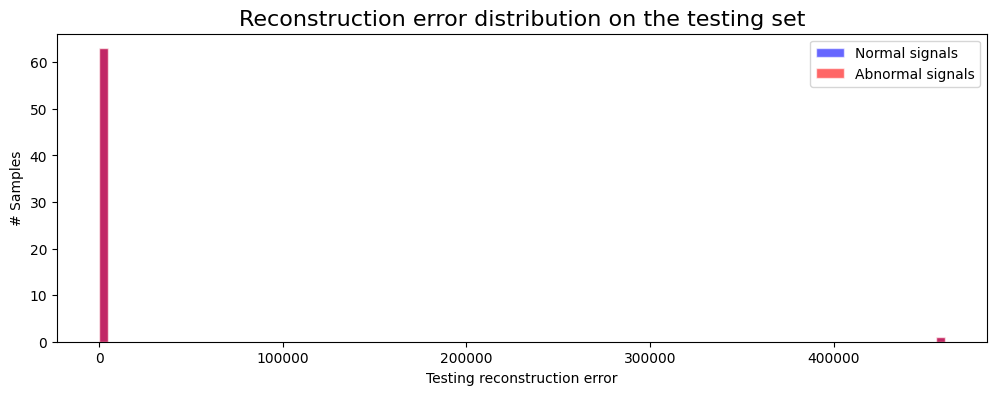

In [26]:
# Shuffling indices
shuffled_indices = np.random.permutation(len(y_true))

# Shuffle the y_true labels and reconstruction_errors based on the shuffled indices
y_true_shuffled = y_true[shuffled_indices]
reconstruction_errors_shuffled = reconstruction_errors[shuffled_indices]

data = np.column_stack((range(len(reconstruction_errors_shuffled)), reconstruction_errors_shuffled))

# Calculate appropriate bin width based on the data range for data with pores
bin_width = (max(reconstruction_errors_shuffled) - min(reconstruction_errors_shuffled)) / 100
bins = np.arange(min(reconstruction_errors_shuffled), max(reconstruction_errors_shuffled) + bin_width, bin_width)

fig = plt.figure(figsize=(12,4))
plt.hist(data[y_true_shuffled==0][:,1], bins=bins, color='blue', alpha=0.6, label='Normal signals', edgecolor='#FFFFFF')
plt.hist(data[y_true_shuffled==1][:,1], bins=bins, color='red', alpha=0.6, label='Abnormal signals', edgecolor='#FFFFFF')
plt.xlabel("Testing reconstruction error")
plt.ylabel("# Samples")
plt.title('Reconstruction error distribution on the testing set', fontsize=16)
plt.legend()
plt.show()



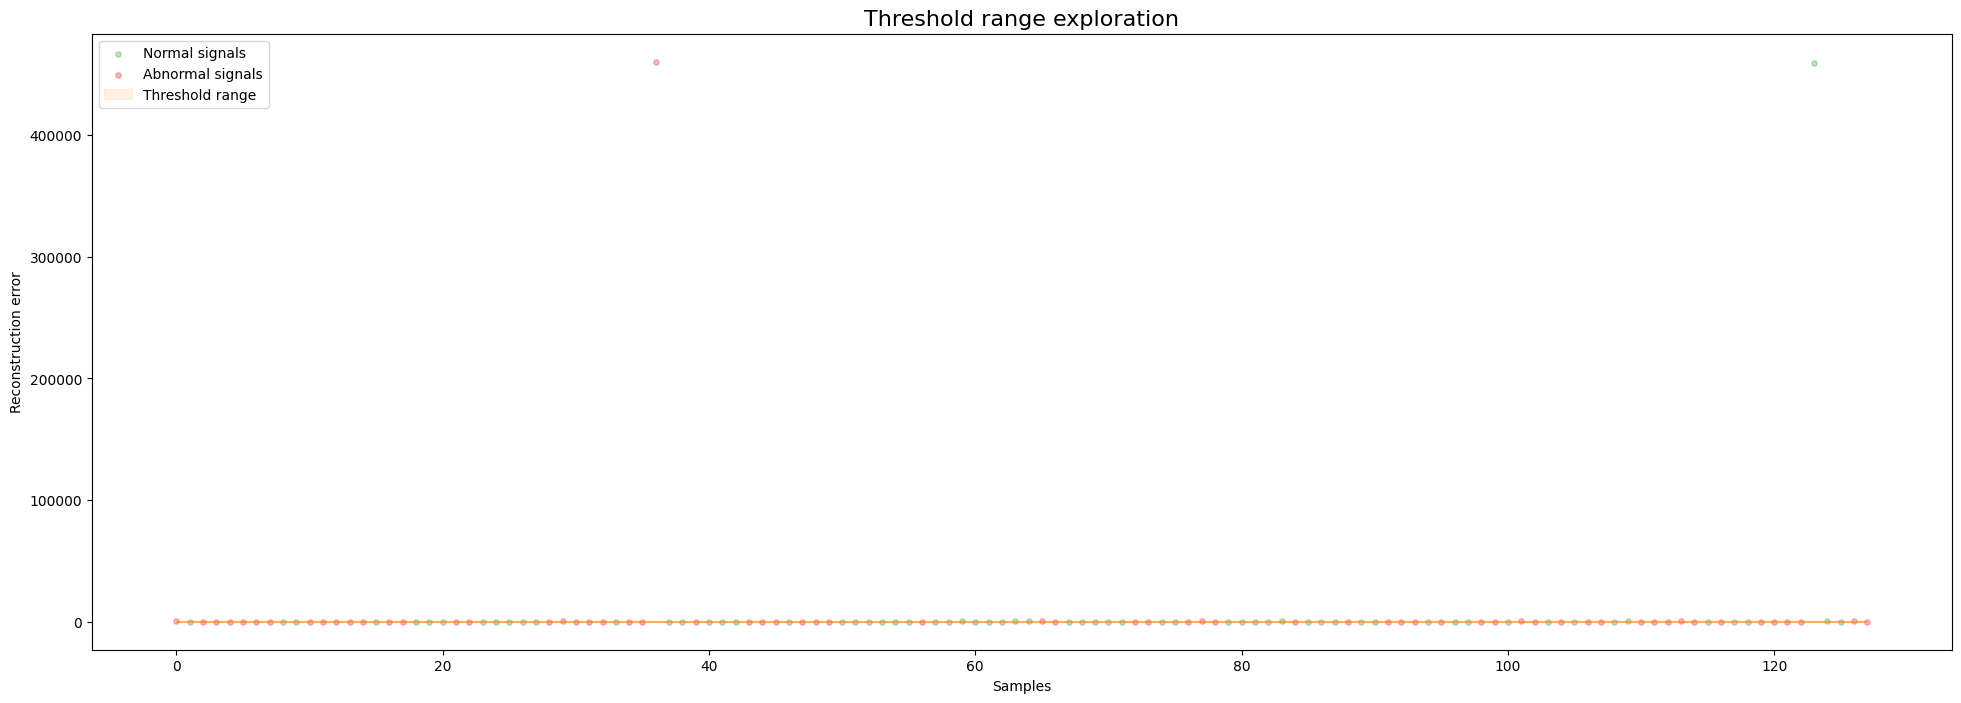

In [27]:
# Set threshold ranges:
threshold_min = 100.0
threshold_max = 1000.0
threshold_step = 0.10
# Scatter data for normal and abnormal signals:
normal_x, normal_y = data[y_true_shuffled==0][:,0], data[y_true_shuffled==0][:,1]
abnormal_x, abnormal_y = data[y_true_shuffled==1][:,0], data[y_true_shuffled==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24,8))
plt.scatter(normal_x, normal_y, s=15, color='tab:green', alpha=0.3, label='Normal signals')
plt.scatter(abnormal_x, abnormal_y, s=15, color='tab:red', alpha=0.3,   label='Abnormal signals')
plt.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='tab:orange', label='Threshold range')
plt.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='tab:orange')
plt.legend(loc='upper left')
plt.title('Threshold range exploration', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Reconstruction error')
plt.show()

In [28]:
import pickle
import numpy as np
import tensorflow as tf

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(test_data, autoencoder):
    reconstruction_errors = []
    for mfcc_data in test_data:
        # Preprocess the MFCC data if needed to match the input shape expected by the Autoencoder
        # For example, reshape or modify dimensions
        mfcc_data = mfcc_data.reshape(-1, 1)
        # Predict the reconstructed output using the Autoencoder
        reconstructed = autoencoder.predict(mfcc_data)
        # Calculate the reconstruction error between original MFCC data and reconstructed output
        reconstruction_error = np.mean(np.square(mfcc_data - reconstructed))
        reconstruction_errors.append(reconstruction_error)
    return np.array(reconstruction_errors)

# Loading testing dataset with pores
test_set_path1 = r"pickles\m2_48hz\test_with_pores_48hz_m2.pickle"
with open(test_set_path1, 'rb') as file:
    test_data_w = pickle.load(file)

# Calculate reconstruction errors for test data with pores
reconstruction_errors_w = calculate_reconstruction_errors(test_data_w, autoencoder)

# Loading testing dataset without pores
test_set_path2 = r"pickles\m2_48hz\test_without_pores_48hz_m2.pickle"
with open(test_set_path2, 'rb') as file:
    test_data_wo = pickle.load(file)

# Calculate reconstruction errors for test data without pores
reconstruction_errors_wo = calculate_reconstruction_errors(test_data_wo, autoencoder)

# Generating labels for the test data without pores
y_true_wo = np.zeros(len(reconstruction_errors_wo))  # Labeling data without pores as normal

# Generating labels for the test data with pores
y_true_w = np.ones(len(reconstruction_errors_w))  # Labeling data with pores as abnormal

# Concatenating labels from both sets to form the combined test labels
y_true = np.concatenate((y_true_wo, y_true_w), axis=0)

# Concatenating reconstruction errors from both sets to form the combined reconstruction errors
reconstruction_errors_combined = np.concatenate((reconstruction_errors_wo, reconstruction_errors_w), axis=0)

# Prepare combined feature set for CNN training
test_data_combined = np.concatenate((test_data_wo, test_data_w), axis=0)
test_data_combined_shuffled = test_data_combined  # Modify this line if shuffling is needed

# Reshape the combined feature set if needed
test_data_combined_shuffled = test_data_combined_shuffled.reshape(test_data_combined_shuffled.shape[0], -1)

# Your CNN architecture for training
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(test_data_combined_shuffled.shape[1],)),  # Adjust input_shape based on your data
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
model.fit(test_data_combined_shuffled, y_true, epochs=100, batch_size=34, validation_split=0.2)

# model.save('cnn_trained_48hz_m2.h5')

75/75 [==============================] - 0s 608us/step
Epoch 1/100
3/3 [==============================] - 0s 59ms/step - loss: 25.7628 - accuracy: 0.4902 - val_loss: 3.0347 - val_accuracy: 0.0769
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 16.6287 - accuracy: 0.6078 - val_loss: 1.6497 - val_accuracy: 0.3462
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 6.5213 - accuracy: 0.5490 - val_loss: 2.6473 - val_accuracy: 0.1154
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 5.5897 - accuracy: 0.5882 - val_loss: 2.1518 - val_accuracy: 0.2308
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 10.2537 - accuracy: 0.6471 - val_loss: 2.0645 - val_accuracy: 0.3462
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 8.2312 - accuracy: 0.5882 - val_loss: 2.2596 - val_accuracy: 0.2692
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 8.5359 - accuracy: 0.6471 - va

C:\Users\Swithinraj M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
# Load the trained CNN model
model_cnn = tf.keras.models.load_model('pickles\m2_48hz\cnn_trained_48hz_m2.h5')


cnn_test_path = r"pickles\m2_48hz\test_with_pores_48hz_m2.pickle"

with open(cnn_test_path, 'rb') as file:
    test_data = pickle.load(file)

# Assuming test_data is a list of NumPy arrays
reshaped_test_data = np.array([mfcc_array.flatten() for mfcc_array in test_data])

# Determine the number of columns based on the size of the original data
num_columns = reshaped_test_data.size // reshaped_test_data.shape[0]

# Ensure that the reshaped_test_data has the correct number of columns
reshaped_test_data = reshaped_test_data.reshape(-1, num_columns)

# Verify the shape of reshaped_test_data
print(reshaped_test_data.shape)

predictions = model_cnn.predict(reshaped_test_data)

(64, 2382)
2/2 [==============================] - 0s 2ms/step


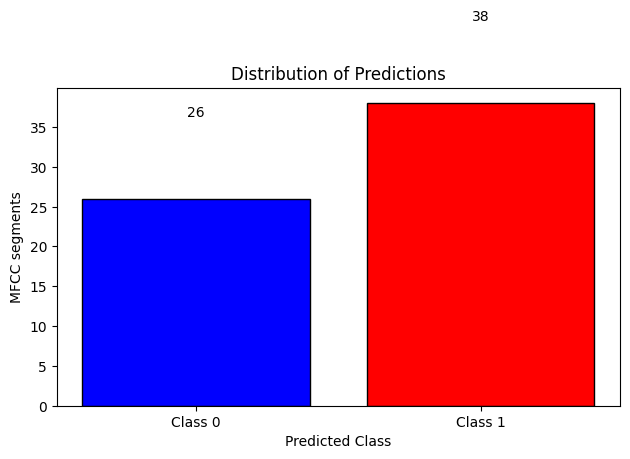

In [43]:
threshold = 0.9
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

# Count occurrences of each class
counts = [binary_predictions.count(0), binary_predictions.count(1)]

# Creating a histogram to visualize the distribution of predictions
plt.bar([0, 1], counts, color=['blue', 'red'], edgecolor='black')

# Labeling bars with their respective frequencies
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.xlabel('Predicted Class')
plt.ylabel('MFCC segments')
plt.xticks([0, 1], ['Class 0', 'Class 1'])  
plt.title('Distribution of Predictions')

plt.tight_layout()
plt.show()